# **Hollywood Moview Recommendation System**

### Instructions to Run the Model  

1. **Import Required Dependencies**: Ensure all necessary libraries and dependencies are imported.  
2. **Load the Dataset**: Import the provided CSV dataset into your environment.  
3. **Execute the Workflow**: Run all code sections sequentially, starting from the EDA (Exploratory Data Analysis) section through to the similarity scores calculation to generate recommendations.  

### Importing required libraries

In [11]:
import pandas as pd
import numpy as np
import requests
import time
from bs4 import BeautifulSoup
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from langchain_community.llms import Ollama
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Importing the dataset from kaggle

In [ ]:
data = pd.read_csv(r"/content/drive/MyDrive/tmdb_5000_movies.csv")
data_filtered = data[data['original_language']=='en']
data_filtered.head()


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


### Fetching the plots using OMDAPI

In [ ]:

def get_movie_plot(movie_title, api_key):
    # Defining the base URL for the OMDb API and specifying the query parameters
    base_url = "https://www.omdbapi.com/"
    params = {
        't': movie_title,  # Setting the movie title to be searched
        'apikey': api_key, # Including the API key for authentication
        'plot': 'full'     # Requesting the full plot for better details
    }

    try:
        # Sending a GET request to the OMDb API and checking for any HTTP errors
        response = requests.get(base_url, params=params)
        response.raise_for_status()

        # Parsing the JSON response from the API
        data = response.json()
        if data.get('Response') == 'True':  # Checking if the response is successful
            return data.get('Plot', 'Plot not available.') # Returning the movie plot
        else:
            # Handling cases where the movie is not found
            return f"Movie not found: {data.get('Error', 'Unknown error.')}"
    except requests.exceptions.RequestException as e:
        # Catching any connection-related errors and returning a descriptive message
        return f"Failed to connect to OMDb API: {str(e)}"

if __name__ == "__main__":
    api_key = "97c73abe"   # Storing the API key for accessing the OMDb API

    # Creating a new column for plots
    data_filtered['plot'] = ''

    # Fetching plots for each movie
    for index, row in data_filtered.iterrows():
        movie_title = row['original_title']
        plot = get_movie_plot(movie_title, api_key)
        data_filtered.at[index, 'plot'] = plot

        # Printing progress
        print(f"Fetched plot for {movie_title}")

        # Adding a short delay between requests to avoid overwhelming the API server
        time.sleep(1)

    # Saving the updated DataFrame
    data_filtered.to_csv('movies_with_plots.csv', index=False)

    print("Finished fetching plots. Updated DataFrame saved to 'movies_with_plots.csv'")

<ipython-input-30-08e289705f81>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['plot'] = ''


Fetched plot for Avatar
Fetched plot for Pirates of the Caribbean: At World's End
Fetched plot for Spectre
Fetched plot for The Dark Knight Rises
Fetched plot for John Carter
Fetched plot for Spider-Man 3
Fetched plot for Tangled
Fetched plot for Avengers: Age of Ultron
Fetched plot for Harry Potter and the Half-Blood Prince
Fetched plot for Batman v Superman: Dawn of Justice
Fetched plot for Superman Returns
Fetched plot for Quantum of Solace
Fetched plot for Pirates of the Caribbean: Dead Man's Chest
Fetched plot for The Lone Ranger
Fetched plot for Man of Steel
Fetched plot for The Chronicles of Narnia: Prince Caspian
Fetched plot for The Avengers
Fetched plot for Pirates of the Caribbean: On Stranger Tides
Fetched plot for Men in Black 3
Fetched plot for The Hobbit: The Battle of the Five Armies
Fetched plot for The Amazing Spider-Man
Fetched plot for Robin Hood
Fetched plot for The Hobbit: The Desolation of Smaug
Fetched plot for The Golden Compass
Fetched plot for King Kong
Fetch

In [ ]:
data_filtered.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,plot
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"When his brother is killed in a robbery, parap..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"After Elizabeth, Will, and Captain Barbossa re..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,A cryptic message from the past sends James Bo...
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Despite his tarnished reputation after the eve...
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"John Carter, a Civil War veteran, who in 1868 ..."


### Fetching the scripts using IMSDB site

In [ ]:

def get_movie_script(movie_title):
    # Setting the base URL for IMSDB and the search URL
    base_url = "https://www.imsdb.com"
    search_url = f"{base_url}/search.php"
    params = {'search': movie_title} # Defining search parameters with the movie title

    try:
        # Sending a GET request to search for the movie on IMSDB
        response = requests.get(search_url, params=params)
        response.raise_for_status()  # Checking for HTTP request errors

        # Parsing the search result page using BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')

        # Searching for the first link to the movie script
        script_link = soup.find('a', href=True, text=movie_title)
        if script_link:
            # Constructing the full URL for the script page
            script_url = base_url + script_link['href']

            # Sending a GET request to fetch the script page
            script_response = requests.get(script_url)
            script_response.raise_for_status()
            script_soup = BeautifulSoup(script_response.text, 'html.parser')

            # Locating the script content
            script_content = script_soup.find('td', {'class': 'scrtext'})
            if script_content:
                return script_content.get_text(strip=True)
            else:
                return f"Script content not found for {movie_title}."
        else:
            return f"Script not found for {movie_title}."
    except requests.exceptions.RequestException as e:
        return f"Failed to fetch script for {movie_title}: {str(e)}"

if __name__ == "__main__":
    # Creating a new column for scripts
    data_filtered['script'] = ''

    # Fetching scripts for each movie
    for index, row in data_filtered.iterrows():
        movie_title = row['original_title']
        print(f"Fetching script for {movie_title}...")
        script = get_movie_script(movie_title)
        data_filtered.at[index, 'script'] = script

        time.sleep(2)

    # Saving the updated DataFrame
    data_filtered.to_csv('movies_with_scripts.csv', index=False)
    print("Finished fetching scripts. Updated DataFrame saved to 'movies_with_scripts.csv'.")


<ipython-input-66-f78c75df01cd>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_populatiry['script'] = ''
<ipython-input-66-f78c75df01cd>:28: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  script_link = soup.find('a', href=True, text=movie_title)


Fetching script for Avatar...
Fetching script for Pirates of the Caribbean: At World's End...
Fetching script for Spectre...
Fetching script for The Dark Knight Rises...
Fetching script for John Carter...
Fetching script for Spider-Man 3...
Fetching script for Tangled...
Fetching script for Avengers: Age of Ultron...
Fetching script for Harry Potter and the Half-Blood Prince...
Fetching script for Batman v Superman: Dawn of Justice...
Fetching script for Superman Returns...
Fetching script for Quantum of Solace...
Fetching script for Pirates of the Caribbean: Dead Man's Chest...
Fetching script for The Lone Ranger...
Fetching script for Man of Steel...
Fetching script for The Chronicles of Narnia: Prince Caspian...
Fetching script for The Avengers...
Fetching script for Pirates of the Caribbean: On Stranger Tides...
Fetching script for Men in Black 3...
Fetching script for The Hobbit: The Battle of the Five Armies...
Fetching script for The Amazing Spider-Man...
Fetching script for Rob

In [ ]:
data_filtered.to_csv('movies_with_scripts_1.csv', index=False)

### Analyzing to get the bert features

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import pandas as pd

# Defining the function to analyze script using BERT
def analyze_script_with_bert(script):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    # Ensuring the script is a string
    if isinstance(script, str):
        inputs = tokenizer(script, return_tensors='pt', truncation=True, max_length=512)
        outputs = model(**inputs)
        last_hidden_state = outputs.last_hidden_state
        pooled_output = torch.mean(last_hidden_state, dim=1)
        return pooled_output.detach().numpy()
    else:
        return None  # Returning None if the script is not a string

data_filtered['script'] = data_filtered['script'].astype(str)  # Checking that all scripts are strings
data_filtered['bert_features'] = data_filtered['script'].apply(analyze_script_with_bert)

print(data_filtered[['script', 'bert_features']].head())


                                              script  \
0  AVATARWritten byJames CameronTHE SOUND OF DRUM...   
1  Read script link not found for Harry Potter an...   
2  PIRATES OF THE CARRIBEAN: DEAD MAN'S CHESTWrit...   
3  MEN IN BLACK 3Written by\r\n\r\n              ...   
4  PRINCE OF THIEVES\r\n                         ...   

                                       bert_features  
0  [[-0.006805107, 0.15600276, 0.33540368, -0.055...  
1  [[0.12368185, -0.357102, -0.086390845, -0.0624...  
2  [[-0.16751707, 0.039543007, 0.3509584, -0.0113...  
3  [[-0.03722561, 0.2779015, 0.31308746, -0.05444...  
4  [[-0.17587593, 0.2335087, 0.28490305, -0.09330...  


In [ ]:
data_filtered.to_csv('movies_with_scripts_1.csv', index=False)

In [ ]:
df_1 = pd.read_csv('/content/drive/MyDrive/movies_with_scripts_1.csv')
df_1

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,plot,script,bert_features
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"When his brother is killed in a robbery, parap...",AVATARWritten byJames CameronTHE SOUND OF DRUM...,[[-6.80510700e-03 1.56002760e-01 3.35403681e...
1,250000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://harrypotter.warnerbros.com/harrypottera...,767,"[{""id"": 616, ""name"": ""witch""}, {""id"": 2343, ""n...",en,Harry Potter and the Half-Blood Prince,"As Harry begins his sixth year at Hogwarts, he...",98.885637,"[{""name"": ""Warner Bros."", ""id"": 6194}, {""name""...",...,153.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Dark Secrets Revealed,Harry Potter and the Half-Blood Prince,7.4,5293,"During Harry Potter's sixth year at Hogwarts, ...",Read script link not found for Harry Potter an...,[[ 1.23681851e-01 -3.57102007e-01 -8.63908455e...
2,200000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,58,"[{""id"": 616, ""name"": ""witch""}, {""id"": 663, ""na...",en,Pirates of the Caribbean: Dead Man's Chest,Captain Jack Sparrow works his way out of a bl...,145.847379,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,151.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Jack is back!,Pirates of the Caribbean: Dead Man's Chest,7.0,5246,Once again we're plunged into the world of swo...,PIRATES OF THE CARRIBEAN: DEAD MAN'S CHESTWrit...,[[-1.67517066e-01 3.95430066e-02 3.50958407e...
3,225000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 35, ""nam...",http://www.sonypictures.com/movies/meninblack3/,41154,"[{""id"": 4379, ""name"": ""time travel""}, {""id"": 5...",en,Men in Black 3,Agents J (Will Smith) and K (Tommy Lee Jones) ...,52.035179,"[{""name"": ""Amblin Entertainment"", ""id"": 56}, {...",...,106.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,They are back... in time.,Men in Black 3,6.2,4160,NaN,MEN IN BLACK 3Written by\r\n\r\n ...,[[-3.72256115e-02 2.77901500e-01 3.13087463e...
4,200000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.robinhoodthemovie.com/,20662,"[{""id"": 4147, ""name"": ""robin hood""}, {""id"": 43...",en,Robin Hood,When soldier Robin happens upon the dying Robe...,37.668301,"[{""name"": ""Imagine Entertainment"", ""id"": 23}, ...",...,140.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,"Rise and rise again, until lambs become lions.",Robin Hood,6.2,1398,Birth of a legend. Following King Richard's (D...,PRINCE OF THIEVES\r\n ...,[[-1.75875932e-01 2.33508706e-01 2.84903049e...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,400000,"[{""id"": 35, ""name"": ""Comedy""}]",NaN,8193,"[{""id"": 240, ""name"": ""underdog""}, {""id"": 380, ...",en,Napoleon Dynamite,A listless and alienated teenager decides to h...,23.603514,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...",...,95.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,He's out to prove he's got nothing to prove.,Napoleon Dynamite,6.7,554,Failed to connect to OMDb API: 401 Client Erro...,Script content not found for Napoleon Dynamite.,[[-2.54264772e-01 -3.76153052e-01 -4.67650503e...
449,250000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.viewaskew.com/chasingamy/,2255,"[{""id"": 586, ""name"": ""new jersey""}, {""id"": 186...",en,Chasing A

### Traning and executing the model

In [15]:
# Additional imports for EDA
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

### EDA

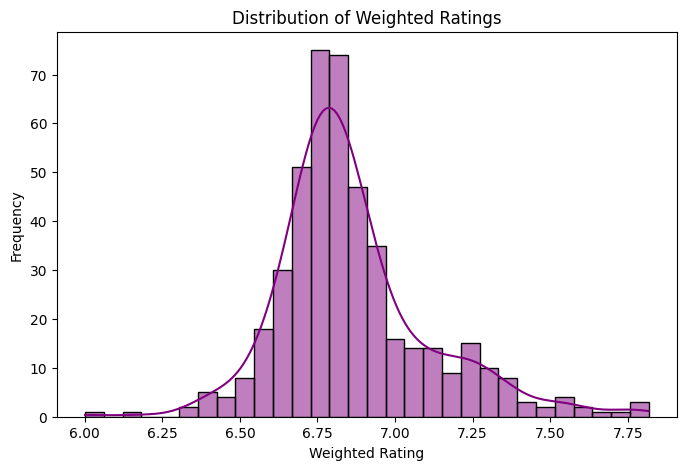

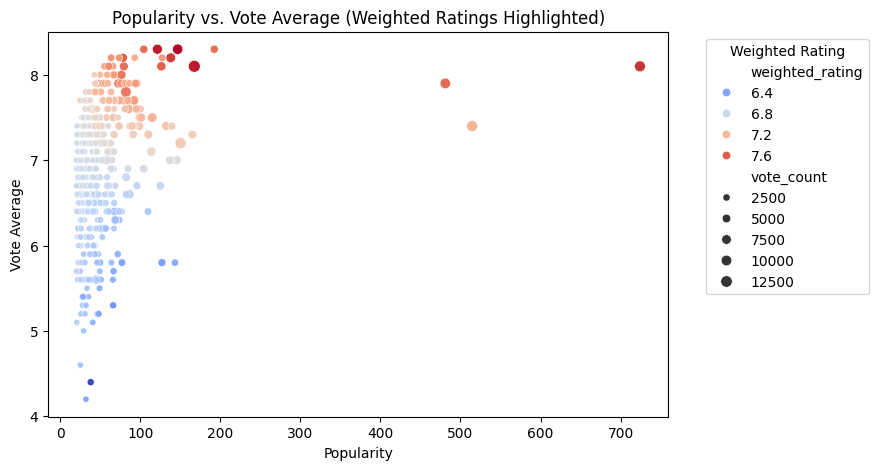

<ipython-input-22-6add2011a608>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_rating', y='title', data=top_movies, palette='plasma')


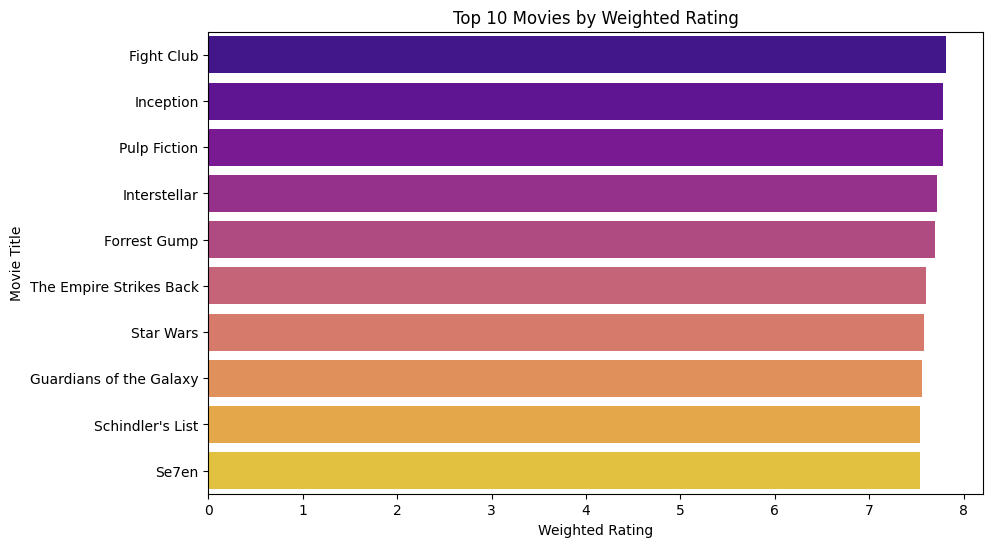

<ipython-input-22-6add2011a608>:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Genre', data=genre_df, palette='viridis')


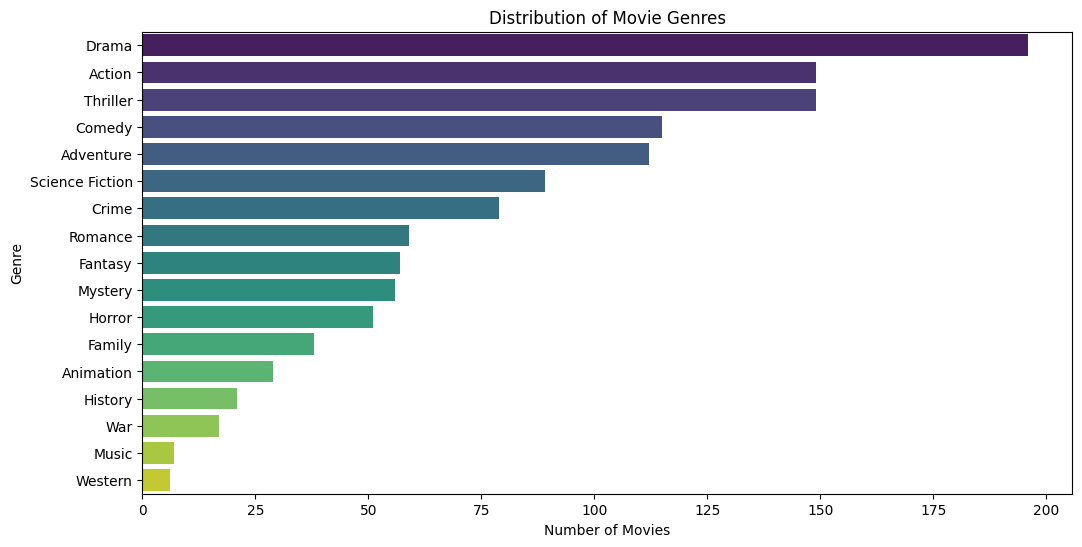

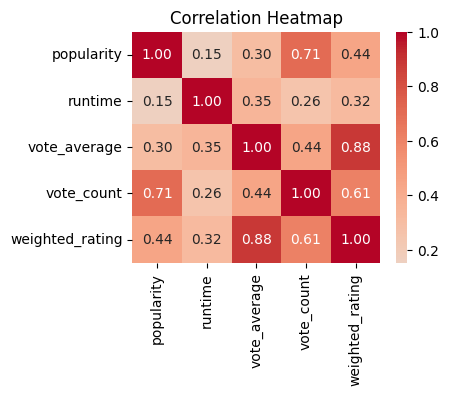

In [22]:
# Loading the data
def load_data(filepath):
    return pd.read_csv(filepath)
# Cleaning and preprocessing numeric data
def preprocess_numeric_data(df):
    df['vote_average'] = pd.to_numeric(df['vote_average'], errors='coerce').fillna(0)
    df['vote_count'] = pd.to_numeric(df['vote_count'], errors='coerce').fillna(0)
    df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce').fillna(0)
    return df
def preprocess_data(df):
    def parse_genres(genre_str):
        try:
            genres = eval(genre_str)
            return ','.join([g['name'] for g in genres])
        except:
            return ""

    df['parsed_genres'] = df['genres'].apply(parse_genres)
    return df
# Calculating weighted rating
def calculate_weighted_rating(df, m_percentile=0.9):

    # Calculating the mean of the 'vote_average' column as the average rating (C)
    C = df['vote_average'].mean()
    # Determining the vote count threshold (m) based on the given percentile
    m = df['vote_count'].quantile(m_percentile)

    # Defining a nested function to compute the weighted rating for each row
    def weighted_rating(row):
        v = row['vote_count']
        R = row['vote_average']
        # Weighted Rating Formula: WR = (v / (v + m) * R) + (m / (v + m) * C),
        # combining average rating (R) with global mean (C) weighted by vote count
        return (v / (v + m) * R) + (m / (v + m) * C)

    df['weighted_rating'] = df.apply(weighted_rating, axis=1)
    return df

# EDA Function
def perform_eda(df):
    # Plot distribution of weighted ratings
    plt.figure(figsize=(8, 5))
    sns.histplot(df['weighted_rating'], kde=True, bins=30, color='purple')
    plt.title('Distribution of Weighted Ratings')
    plt.xlabel('Weighted Rating')
    plt.ylabel('Frequency')
    plt.show()

    # Scatter plot of popularity vs. vote average
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x='popularity', y='vote_average', size='vote_count', hue='weighted_rating', data=df, palette='coolwarm')
    plt.title('Popularity vs. Vote Average (Weighted Ratings Highlighted)')
    plt.xlabel('Popularity')
    plt.ylabel('Vote Average')
    plt.legend(title='Weighted Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    # Top movies by weighted rating
    top_movies = df.sort_values('weighted_rating', ascending=False).head(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='weighted_rating', y='title', data=top_movies, palette='plasma')
    plt.title('Top 10 Movies by Weighted Rating')
    plt.xlabel('Weighted Rating')
    plt.ylabel('Movie Title')
    plt.show()

    # Genre distribution
    all_genres = [genre.strip() for genres in df['parsed_genres'] for genre in genres.split(',') if genre.strip()]
    genre_counts = Counter(all_genres)
    genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Count', y='Genre', data=genre_df, palette='viridis')
    plt.title('Distribution of Movie Genres')
    plt.xlabel('Number of Movies')
    plt.ylabel('Genre')
    plt.show()

    # Plotting correlation heatmap for all numerical features excluding 'budget', 'id', and 'revenue'
    numeric_features = df.select_dtypes(include=['float64', 'int64']).columns  # Selecting numeric columns only
    numeric_features_to_include = [col for col in numeric_features if col not in ['budget', 'id', 'revenue']]  # Excluding unimportant columns
    correlation_matrix = df[numeric_features_to_include].corr()  # Calculating correlation among the filtered numeric columns

    plt.figure(figsize=(4, 3))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap')
    plt.show()


if __name__ == "__main__":
    filepath = '/content/drive/MyDrive/movies_with_scripts_1.csv'
    df = load_data(filepath)
    df = preprocess_numeric_data(df)
    df = preprocess_data(df)
    df = df.dropna(subset=['parsed_genres'])
    df = calculate_weighted_rating(df)
    perform_eda(df)


### Preprocessing the data and computing recommendations and similarity scores

In [80]:
# Defining weights for the scoring mechanism
CONTENT_WEIGHT = 0.5
GENRE_WEIGHT = 0.5
BERT_WEIGHT = 0.25
SIMILARITY_THRESHOLD = 0.5

# Loading the data
def load_data(filepath):
    return pd.read_csv(filepath)

# Preprocessing data
def preprocess_data(df):
    def parse_genres(genre_str):
        try:
            genres = eval(genre_str)
            return ','.join([g['name'] for g in genres])
        except:
            return ""

    def convert_to_numeric_array(features):
        try:
            return np.array(eval(features)) if isinstance(features, str) else np.array(features)
        except:
            return np.zeros(768)  # Adjust size based on your BERT output

    # Checking that bert_features are correctly parsed and converted to numeric arrays
    df['bert_features'] = df['bert_features'].apply(convert_to_numeric_array)
    df['parsed_genres'] = df['genres'].apply(parse_genres)
    df['combined_text'] = (
        df['parsed_genres'] + ' ' +
        df['tagline'].fillna('') + ' ' +
        df['overview'].fillna('') + ' ' +
        df['plot'].fillna('')
    )

    # Applying TF-IDF
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['combined_text'])

    # Performing SVD on numeric features
    numeric_features = np.hstack((
        df[['vote_average', 'vote_count', 'popularity']].fillna(0).values,
        np.vstack(df['bert_features'])
    ))
    scaled_numeric_features = StandardScaler().fit_transform(numeric_features)
    svd = TruncatedSVD(n_components=3, random_state=42)
    svd_matrix = svd.fit_transform(scaled_numeric_features)

    # Penalizing larger singular values
    l2_penalty = 0.1
    svd_matrix = svd_matrix / (1 + l2_penalty)

    # Combining features
    combined_matrix = np.hstack((svd_matrix, tfidf_matrix.toarray()))
    content_similarity = cosine_similarity(combined_matrix)

    return df, tfidf_vectorizer, content_similarity

# Computing genre similarity
def compute_genre_similarity(df, genres):
    def compute_genre_match_score(parsed_genres):
        genre_list = parsed_genres.split(',')
        match_count = sum([1 for genre in genres.split(',') if genre.strip().lower() in [g.strip().lower() for g in genre_list]])
        return match_count / len(genre_list) if genre_list else 0

    df['genre_match_score'] = df['parsed_genres'].apply(compute_genre_match_score)
    genre_similarity_adjusted = cosine_similarity(df[['genre_match_score']])
    return genre_similarity_adjusted


# Recommending movies
def recommend_movies(prompt, df, content_similarity, num_recommendations=5):
    try:
        genres = ",".join([word.capitalize() for word in prompt.split() if len(word) > 3])
        genre_similarity_adjusted = compute_genre_similarity(df, genres)
        # Calculate final scores
        final_scores = []
        for i in range(len(content_similarity)):
            final_score = (
                CONTENT_WEIGHT * content_similarity[i, i] +
                GENRE_WEIGHT * genre_similarity_adjusted[i, i]
            )
            final_scores.append((i, final_score))

        # Sorting by final score
        sorted_scores = sorted(final_scores, key=lambda x: x[1], reverse=True)
        top_indices = [i[0] for i in sorted_scores[:num_recommendations]]
        recommended_movies = df.iloc[top_indices][['title', 'parsed_genres', 'popularity', 'runtime']]
        scores = [sorted_scores[i][1] for i in range(num_recommendations)]

        return recommended_movies, scores
    except Exception as e:
        return None, f"Error: {str(e)}"

if __name__ == "__main__":
    filepath = '/content/drive/MyDrive/movies_with_scripts_1.csv'
    df = load_data(filepath)
    df, tfidf_vectorizer, content_similarity = preprocess_data(df)



    # User prompt
    prompt = input("Enter your movie preferences (e.g., 'a thrilling comedy'): ")
    recommended_movies, scores = recommend_movies(prompt, df, content_similarity)

    if recommended_movies is None:
        print(f"Error: {scores}")
    else:
        print("\nHere are some recommendations based on your preferences:\n")
        for index, row in recommended_movies.iterrows():
            score = scores[recommended_movies.index.get_loc(index)]
            print(f"- {row['title']}, Genres: ({row['parsed_genres']}), Popularity: {row['popularity']:.2f}, Score: {score:.2f}, Runtime in mins: {row['runtime']:.2f}")


Enter your movie preferences (e.g., 'a thrilling comedy'): An adventure film

Here are some recommendations based on your preferences:

- Frozen, Genres: (Animation,Adventure,Family), Popularity: 165.13, Score: 1.00, Runtime in mins: 102.00
- Star Trek, Genres: (Science Fiction,Action,Adventure), Popularity: 73.62, Score: 1.00, Runtime in mins: 127.00
- How to Train Your Dragon 2, Genres: (Fantasy,Action,Adventure,Animation,Comedy,Family), Popularity: 100.21, Score: 1.00, Runtime in mins: 102.00
- Harry Potter and the Prisoner of Azkaban, Genres: (Adventure,Fantasy,Family), Popularity: 79.68, Score: 1.00, Runtime in mins: 141.00
- Conan the Barbarian, Genres: (Adventure,Fantasy,Action), Popularity: 31.80, Score: 1.00, Runtime in mins: 129.00


### Plotting the similarity scores for an example prompt

Enter your movie preferences (e.g., 'a thrilling comedy'): An adventure movie

Here are some recommendations based on your preferences:

- Frozen, Genres: (Animation,Adventure,Family), Popularity: 165.13, Score: 1.00, Runtime in mins: 102.00
- Star Trek, Genres: (Science Fiction,Action,Adventure), Popularity: 73.62, Score: 1.00, Runtime in mins: 127.00
- How to Train Your Dragon 2, Genres: (Fantasy,Action,Adventure,Animation,Comedy,Family), Popularity: 100.21, Score: 1.00, Runtime in mins: 102.00
- Harry Potter and the Prisoner of Azkaban, Genres: (Adventure,Fantasy,Family), Popularity: 79.68, Score: 1.00, Runtime in mins: 141.00
- Conan the Barbarian, Genres: (Adventure,Fantasy,Action), Popularity: 31.80, Score: 1.00, Runtime in mins: 129.00


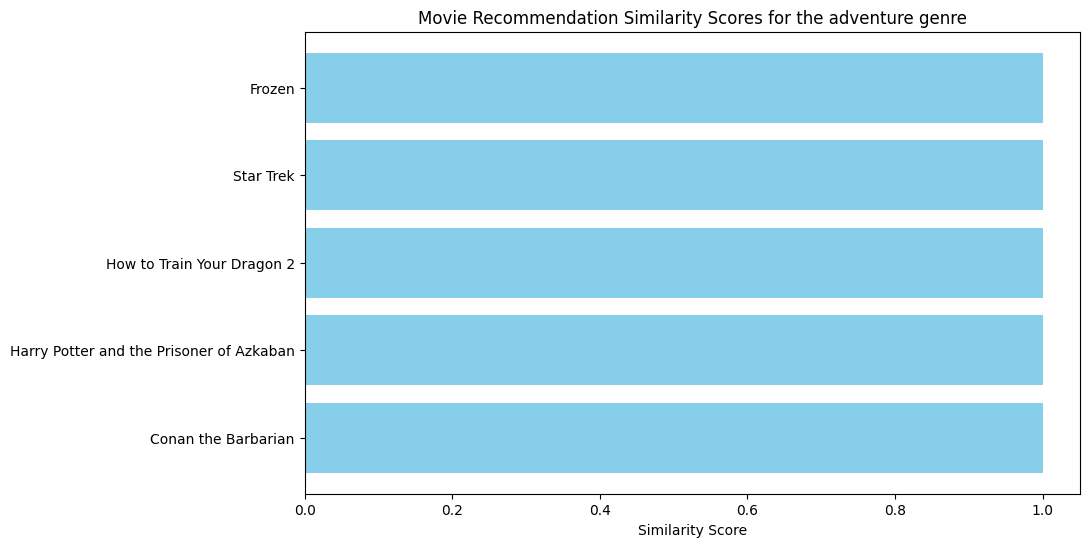

In [82]:

# Function to plot similarity scores
def plot_similarity_scores(recommended_movies, scores):
    try:
        # Extract the movie titles and corresponding similarity scores
        movie_titles = recommended_movies['title']

        # Create a bar plot for similarity scores
        plt.figure(figsize=(10, 6))
        plt.barh(movie_titles, scores, color='skyblue')
        plt.xlabel('Similarity Score')
        plt.title('Movie Recommendation Similarity Scores for the adventure genre')
        plt.gca().invert_yaxis()  # Invert the y-axis to display the highest score at the top
        plt.show()
    except Exception as e:
        print(f"Error in plotting: {str(e)}")

# Main execution
if __name__ == "__main__":
    filepath = '/content/drive/MyDrive/movies_with_scripts_1.csv'
    df = load_data(filepath)
    df, tfidf_vectorizer, content_similarity = preprocess_data(df)

    # User prompt
    prompt = input("Enter your movie preferences (e.g., 'a thrilling comedy'): ")
    recommended_movies, scores = recommend_movies(prompt, df, content_similarity)

    if recommended_movies is None:
        print(f"Error: {scores}")
    else:
        print("\nHere are some recommendations based on your preferences:\n")
        for index, row in recommended_movies.iterrows():
            score = scores[recommended_movies.index.get_loc(index)]
            print(f"- {row['title']}, Genres: ({row['parsed_genres']}), Popularity: {row['popularity']:.2f}, Score: {score:.2f}, Runtime in mins: {row['runtime']:.2f}")

        # Call the plot function to display similarity scores
        plot_similarity_scores(recommended_movies, scores)


### Instructions to set up llama3

Colab-xterm allows you to open a terminal in a cell.

Install package and load the extension
!pip install colab-xterm %load_ext colabxterm

Open a terminal

%xterm

Now, terminal will open in the colab. Install the Ollama in the terminal using Linux command.

curl -fsSL https://ollama.com/install.sh | sh

Pull Llama3 model

ollama serve & ollama pull llama3

Good to go !!

### Setting up llama3

In [7]:
!pip install langchain_community

!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.7/409.7 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.21
    Uninstalling langchain-core-0.3.21:
      Successfully uninstalled langchain-core-0.3.21
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.9
    Uninstalling langchain-0.3.9:
      Successfully uninstalled langchain-0.3.9


In [8]:
!pip install langchain
!pip install langchain-core

In [9]:
!pip install colab-xterm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 4.1 MB/s eta 0:00:00


In [10]:
%load_ext colabxterm
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

### Creating an app.py file with required functions to run in Streamlit

In [12]:
%%writefile app.py

import streamlit as st
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from langchain_community.llms import Ollama

# Caching data and models to improve efficiency
@st.cache_resource
def load_llm():
    try:
        return Ollama(model="llama3")
    except Exception as e:
        return None

@st.cache_data
def load_data():
    df = pd.read_csv('/content/drive/MyDrive/movies_with_scripts_1.csv')
    return df

@st.cache_data
def preprocess_data(df):
    def parse_genres(genre_str):
        try:
            genres = eval(genre_str)
            return ','.join([g['name'] for g in genres])
        except:
            return ""

    # Converting bert_features to numeric arrays
    def convert_to_numeric_array(features):
        try:
            # Checking bert_features is a list of numerical values
            return np.array(eval(features)) if isinstance(features, str) else np.array(features)
        except:
            return np.zeros(768)  # Default to a zero vector if conversion fails

    # Ensuring bert_features are correctly parsed and converted to numeric arrays
    df['bert_features'] = df['bert_features'].apply(convert_to_numeric_array)

    df['parsed_genres'] = df['genres'].apply(parse_genres)
    df['combined_text'] = (
        df['parsed_genres'] + ' ' +
        df['tagline'].fillna('') + ' ' +
        df['overview'].fillna('') + ' ' +
        df['plot'].fillna('')
    )
    # Applying TF-IDF
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['combined_text'])

    # Performing SVD on numeric features
    numeric_features = np.hstack((
        df[['vote_average', 'vote_count', 'popularity']].fillna(0).values,
        np.vstack(df['bert_features'])
    ))
    scaled_numeric_features = StandardScaler().fit_transform(numeric_features)
    svd = TruncatedSVD(n_components=3, random_state=42)
    svd_matrix = svd.fit_transform(scaled_numeric_features)

    # Penalizing larger singular values
    l2_penalty = 0.1
    svd_matrix = svd_matrix / (1 + l2_penalty)

    # Combine features
    combined_matrix = np.hstack((svd_matrix, tfidf_matrix.toarray()))
    content_similarity = cosine_similarity(combined_matrix)

    return df, tfidf_vectorizer, content_similarity

# Initialize data and LLM
llm = load_llm()
df = load_data()
df, tfidf_vectorizer, content_similarity = preprocess_data(df)

# Initialize session state for chat
if "chat_history" not in st.session_state:
    st.session_state.chat_history = [{"role": "assistant", "content": "How may I assist you today?"}]
def process_prompt_with_ollama(prompt):
    """
    Process the user's prompt using Ollama to extract relevant genres or themes.
    Falls back to a simple keyword extraction if Ollama is unavailable.
    """
    if llm:
        try:
            system_instruction = (
                "Extract the main genres or themes from the user's movie recommendation prompt. "
                "Respond with a comma-separated list of genres like 'Comedy, Thriller'."
            )
            response = llm.invoke(f"{system_instruction} User prompt: {prompt}")
            return response.strip()
        except Exception:
            pass
    # Fallback method: simple keyword extraction
    return ",".join([word.capitalize() for word in prompt.split() if len(word) > 3])

def recommend_movies_with_ollama(prompt, num_recommendations=5, genre_weight=0.3, content_weight=0.7):
    try:
        # Extracting genres using Ollama
        genres = process_prompt_with_ollama(prompt)
        if not genres:
            return "No relevant movies found for the given prompt."

        # Matching extracted genres with parsed genres in the dataset
        def compute_genre_match_score(parsed_genres):
            genre_list = parsed_genres.split(',')
            match_count = sum([1 for genre in genres.split(',') if genre.strip().lower() in [g.strip().lower() for g in genre_list]])
            return match_count / len(genre_list) if genre_list else 0

        df['genre_match_score'] = df['parsed_genres'].apply(compute_genre_match_score)

        # Adjusting similarity scores
        genre_similarity_adjusted = cosine_similarity(
            np.array(df['genre_match_score']).reshape(-1, 1)
        )

        combined_scores = []
        for i in range(len(content_similarity)):
            combined_score = (
                content_weight * content_similarity[i, i] +
                genre_weight * genre_similarity_adjusted[i, i]
            )
            combined_scores.append((i, combined_score))

        # Sorting by similarity
        sorted_scores = sorted(combined_scores, key=lambda x: x[1], reverse=True)
        top_indices = [i[0] for i in sorted_scores[:num_recommendations]]
        recommended_movies = df.iloc[top_indices][['title', 'parsed_genres', 'popularity', 'runtime']]
        scores = [sorted_scores[i][1] for i in range(num_recommendations)]

        return recommended_movies, scores
    except Exception as e:
        return None, f"Error processing prompt: {str(e)}"
st.title("Movie Recommendation Chatbot")

# Display chat history using chat_message
for message in st.session_state.chat_history:
    with st.chat_message(message["role"]):
        st.write(message["content"])

if prompt := st.chat_input(placeholder="Enter your movie preferences (e.g., 'a thrilling comedy')"):
    # Add user input to chat history
    st.session_state.chat_history.append({"role": "user", "content": prompt})
    with st.chat_message("user"):
        st.write(prompt)

    # Generate assistant response
    with st.chat_message("assistant"):
        with st.spinner("Fetching recommendations..."):
            try:
                # Generate recommendations
                recommended_movies, scores = recommend_movies_with_ollama(prompt)
                if recommended_movies is None:
                    response = scores  # This contains error messages if an exception occurred
                else:
                    # Format recommendations
                    response_lines = ["Here are some recommendations based on your preferences:\n"]
                    for _, row in recommended_movies.iterrows():
                        response_lines.append(
                            f"- **{row['title']}**, **Genres:** ({row['parsed_genres']}), **Popularity:** {row['popularity']:.2f}, **Runtime in mins:** {row['runtime']:.2f} "
                        )
                    response = "\n".join(response_lines)
            except Exception as e:
                response = f"An error occurred: {str(e)}"

            # Append and display assistant's response
            st.session_state.chat_history.append({"role": "assistant", "content": response})
            st.write(response)



Overwriting app.py


### Installing and calling required dependencies to run Streamlit

In [1]:
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.1 MB/s eta 0:00:00


In [2]:
!npm install -g localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴
added 22 packages in 5s
⠴
⠴3 packages are looking for funding
⠴  run `npm fund` for details
⠴

In [13]:
!streamlit run app.py &>/content/logs.txt &

In [14]:
!npx localtunnel --port 8501

⠙⠹⠸⠼⠴your url is: https://fancy-teams-nail.loca.lt
^C


In [4]:
!wget -q -O - ipv4.icanhazip.com


34.105.54.65
